In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, optimize
import functools, operator

%matplotlib inline

In [2]:
a = sp.var("a:4")
t = sp.var("t")

u = a0 + a1*t + a2/2*t**2 + a3/6*t**3
ta, tb = sp.solve(u.diff(t), t)


In [3]:
def halfgen4(up, n):
    """
    http://recycle.lbl.gov/~ldoolitt/halfband

    params:
        * `up` is the stopband width, as a fraction of input sampling rate
        * `n is the order of half-band filter to generate
    returns:
        * `a` is the full set of FIR coefficients, `4*n-1` long.
          implement wisely.
    """

    npt = n*60
    wmax = 2*np.pi*up
    wfit = (1 - np.linspace(0, 1, npt)[:, None]**2)*wmax

    target = .5*np.ones_like(wfit)
    basis = np.cos(wfit*np.arange(1, 2*n, 2))
    l = np.linalg.pinv(basis)@target

    weight = np.ones_like(wfit)
    for i in range(60):
        err = np.fabs(basis@l - .5)
        weight[err > 0.99*np.max(err)] *= 1 + 1.5/(i + 11)
        l = np.linalg.pinv(basis*weight)@(target*weight)
    a = np.c_[l, np.zeros_like(l)].ravel()[:-1]
    a = np.r_[a[::-1], 1, a]/2
    return a

(-70.0, 6.0)

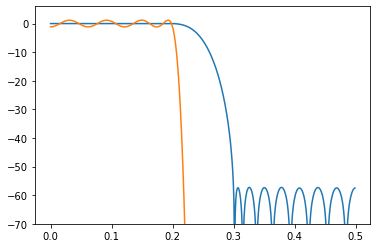

In [4]:
a = halfgen4(.40/2, 8)
a = np.round((1 << 16) * a)/(1 << 16)
a
#plt.plot(a)
w, h = signal.freqz(a)
plt.plot(w/(2*np.pi), 20*np.log10(np.absolute(h)))
plt.plot(w/(2*np.pi), 2000*np.log10(np.absolute(h)))
plt.ylim(-70, 6)

(-90.0, 6.0)

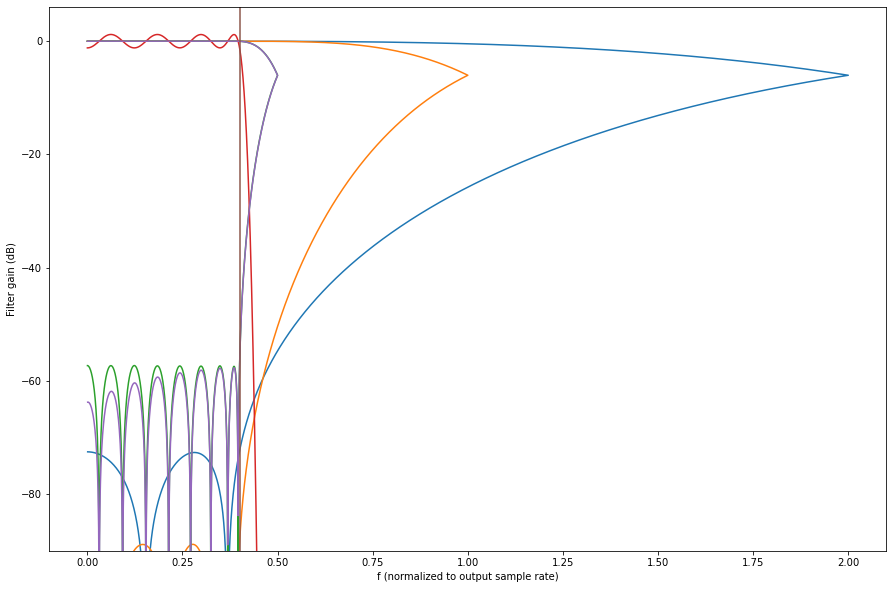

In [5]:
f = np.arange(0, .5, .0001)
fa = .5 - np.fabs(2*f - .5)
z = np.exp(2j*np.pi*f)
k = .2
s = (1 << 18)

A2 = halfgen4(k/4, 2)
A2 = np.round(s * A2)/s
O2 = np.polyval(A2, z)

A4 = halfgen4(k/2, 4)
A4 = np.round(s * A4)/s
O4 = np.polyval(A4, z)

A8 = halfgen4(k, 8)
A8 = np.round(s * A8)/s
O8 = np.polyval(A8, z)

fig, ax = plt.subplots(figsize=(15, 10))
#text(0.37, -30, '74% Nyquist', 'horizontalalignment', 'center', 'fontsize', 18);
ax.set_xlabel('f (normalized to output sample rate)')
ax.set_ylabel('Filter gain (dB)')

ax.plot(
    fa*4, np.log10(np.absolute(O2))*20,
    fa*2, np.log10(np.absolute(O4))*20,
    fa, np.log10(np.absolute(O8))*20,
    fa, np.log10(np.absolute(O8))*20*100,
    fa[::4], np.log10(np.absolute(O8[::4]*O4[:len(O4)//2:2]*O2[:len(O2)//4]))*20,
    [k*2, k*2], [-90, 6],
)
ax.set_ylim(-90, 6)
#ax.set_xlim(.36, .5)

31
[-0.00210571  0.          0.00465393  0.         -0.00942993  0.
  0.01721191  0.         -0.02978516  0.          0.05152893  0.
 -0.09841919  0.          0.31567383  0.5         0.31567383  0.
 -0.09841919  0.          0.05152893  0.         -0.02978516  0.
  0.01721191  0.         -0.00942993  0.          0.00465393  0.
 -0.00210571]
31
[-0.00210571  0.          0.00465393  0.         -0.00942993  0.
  0.01721191  0.         -0.02978516  0.          0.05152893  0.
 -0.09841919  0.          0.31567383  0.5         0.31567383  0.
 -0.09841919  0.          0.05152893  0.         -0.02978516  0.
  0.01721191  0.         -0.00942993  0.          0.00465393  0.
 -0.00210571]


(0.0, 0.25)

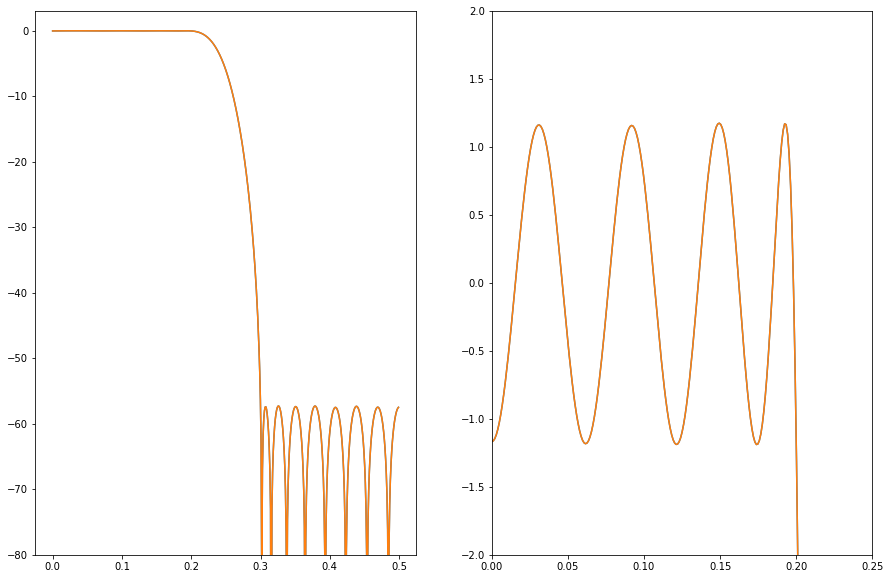

In [6]:
# sawg f1/f2 inteprolation filter

up = .2
n = 8

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
for a in [
    halfgen4(up, n),
    signal.remez(4*n - 1, [0, up, .5 - up, .5], [1, 0], grid_density=40),
    #signal.firwin(4*n - 1, .5),
]:
    a[np.fabs(a) < np.fabs(a[0])] = 0
    a = np.round((1 << 16) * a)/(1 << 16)
    print(len(a))
    print(a)
    w, h = signal.freqz(a)
    ax[0].plot(w/(2*np.pi), 20*np.log10(np.absolute(h)))
    ax[1].plot(w/(2*np.pi), 2000*np.log10(np.absolute(h)))

ax[0].set_ylim(-80, 3)
ax[1].set_ylim(-2, 2)
ax[1].set_xlim(0, .25)

55
[-6.10351562e-05  0.00000000e+00  2.13623047e-04  0.00000000e+00
 -5.18798828e-04  0.00000000e+00  1.09863281e-03  0.00000000e+00
 -2.10571289e-03  0.00000000e+00  3.72314453e-03  0.00000000e+00
 -6.22558594e-03  0.00000000e+00  9.91821289e-03  0.00000000e+00
 -1.53198242e-02  0.00000000e+00  2.32238770e-02  0.00000000e+00
 -3.53393555e-02  0.00000000e+00  5.60302734e-02  0.00000000e+00
 -1.01348877e-01  0.00000000e+00  3.16711426e-01  5.00000000e-01
  3.16711426e-01  0.00000000e+00 -1.01348877e-01  0.00000000e+00
  5.60302734e-02  0.00000000e+00 -3.53393555e-02  0.00000000e+00
  2.32238770e-02  0.00000000e+00 -1.53198242e-02  0.00000000e+00
  9.91821289e-03  0.00000000e+00 -6.22558594e-03  0.00000000e+00
  3.72314453e-03  0.00000000e+00 -2.10571289e-03  0.00000000e+00
  1.09863281e-03  0.00000000e+00 -5.18798828e-04  0.00000000e+00
  2.13623047e-04  0.00000000e+00 -6.10351562e-05]


(-0.6, 0.0)

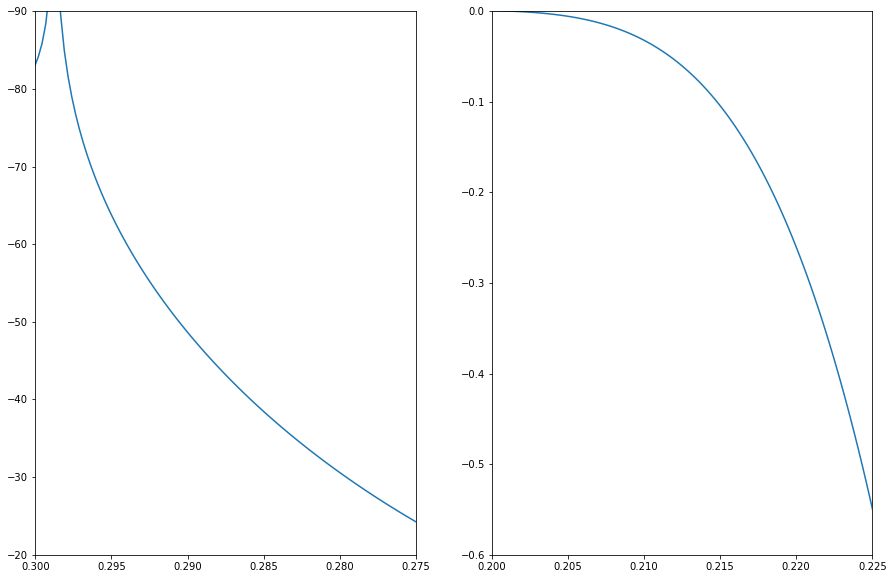

In [7]:
# ad9154 interpolation filter: .2 transition width, 14 taps

up = .2
n = 14

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
for a in [
    halfgen4(up, n),
    #signal.remez(4*n - 1, [0, up, .5 - up, .5], [1, 0], grid_density=60),
    #signal.firwin(4*n - 1, .5),
]:
    a[np.fabs(a) < np.fabs(a[0])] = 0
    a = np.round((1 << 15) * a)/(1 << 15)
    print(len(a))
    print(a)
    w, h = signal.freqz(a, worN=1<<11)
    ax[0].plot(w/(2*np.pi), 20*np.log10(np.absolute(h)))
    ax[1].plot(w/(2*np.pi), 20*np.log10(np.absolute(h)))

ax[0].set_xlim(.3, .275)
ax[0].set_ylim(-20, -90)
ax[1].set_xlim(.2, .225)
ax[1].set_ylim(-.6, 0)

In [8]:
# 4 ns cycles, 250 MHz
# 42.67 ns/sample / 4 ns/cycle = 3/32 samples/cycle
# 2x 3/16
# 2x 3/8
# 2x 3/4
# /3 1/4
# 8x 2/1
# lvds
# dac 2x 2/1: 2*2*250 MS/s

In [9]:
# usable bandwidth, MHz
3/32/4e-3*.84

19.6875

In [10]:
# 3 samples, 2 channels, 2 quadratures, 14 bit into 32 cycles, 6 lanes
# residual bits for framing and misc
32*6-3*2*2*14

24

In [11]:
class Process:
    rate = 1

    
class Gain(Process):
    def __init__(self, g):
        self.gain = g

    def __call__(self, x):
        return x*self.gain


class US(Process):
    def __init__(self, r):
        self.rate = r

    def __call__(self, x):
        return np.vstack((x*self.rate, np.zeros((self.rate - 1, len(x))))).T.ravel()


class DS(Process):
    def __init__(self, r, prefer_mid=True):
        self.r = r
        self.rate = 1./r
        self.prefer_mid = prefer_mid
        
    def __call__(self, x):
        if self.prefer_mid:
            start = (len(x) - 1) // 2 % self.r
        else:
            start = 0
        return x[start::self.r]

    
class FIR(Process):
    def __init__(self, b, a=1):
        b = np.atleast_1d(b)
        # b[np.fabs(b) < 3e-7] = 0
        self.b, self.a = b, a

    def __call__(self, x):
        return np.convolve(x, self.b)/self.a

    def quantize(self, m):
        self.b = np.round(self.b*m).astype(np.int32)
        self.a = np.round(self.a*m).astype(np.int32)
        return self
    
    def freqz(self, worN=1024):
        return signal.freqz(self.b, self.a, worN)

    def plot_freq(self, ax, color=None, r=1, f=1, inset=True, worN=1024):
        s, h = self.freqz(worN)
        s /= np.pi*f
        hh = np.absolute(h/r)
        ax.plot(s, hh, color=color)
        if inset:
            ax.plot(s, np.fabs(1 - hh), color=color)

    def plot_time(self, ax, color=None, r=1):
        ax.step(np.arange(len(self.b))/r, self.b/self.a, color=color)


class LPF(FIR):
    def __init__(self, n, wa, wb, k=(1., 1), g=(1., 0)):
        b = signal.remez(
            numtaps=n,
            bands=(0, wa, wb, 1.),
            desired=g,
            weight=k,
            fs=2,
            grid_density=256)
        FIR.__init__(self, b)


class HBF(LPF):
    def __init__(self, n, w):
        LPF.__init__(self, 4*n - 1, w, 1 - w)


class FIR2(FIR):
    def __init__(self, n, w, g):
        b = signal.firwin2(n, w, g)
        FIR.__init__(self, b)


class FIRLS(FIR):
    def __init__(self, n, w, g, weight=None):
        b = signal.firls(n, w, g, weight)
        FIR.__init__(self, b)


class CIC(FIR):
    def __init__(self, r, m, n):
        # self.rate = r if r > 0 else -1/r
        self.rate = 1  # use a US/DS before to implement the rate change
        self.r = r  # rate change
        self.m = m  # delay
        self.n = n  # filter order
        b = 1
        a = 1
        for i in range(n):
            b = np.convolve(np.ones(abs(r)*m, np.int32), b)
            a *= abs(r)*m
        FIR.__init__(self, b, a)
        #b = 1  #[max(r, 1)] + [0]*(max(r, 1) - 1)
        #b = b[::max(1, -r)]/max(1, -r)

    def disabled__call__(self, x):  # not yet working
        k = (1 << 30)/np.fabs(x).max()
        x = (x*k).astype(np.int64)
        if self.r > 0:
            for i in range(self.n):
                x = np.diff(np.r_[0, x], self.m)
            x = US(self.r)(x)
            for i in range(self.n):
                x = np.cumsum(x)
        else:
            for i in range(self.n):
                x = np.cumsum(x)
            x = DS(-self.r)(x)
            for i in range(self.n):
                x = np.diff(np.r_[0, x], self.m)
        return x/k

In [12]:
# CIC: http://www.tsdconseil.fr/log/scriptscilab/cic/cic-en.pdf
# resampling: http://www.ee.ic.ac.uk/hp/staff/dmb/courses/DSPDF/01300_Resampling.pdf

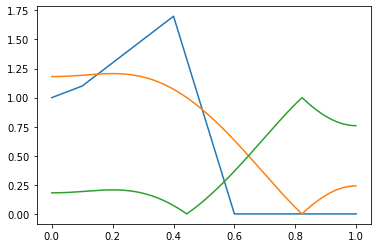

In [13]:
def ls(f, b0, s, h, k=None):
    s = np.atleast_1d(s)
    h = np.atleast_1d(h)
    assert s.shape == h.shape

    if k is None:
        k = np.ones_like(h)
    
    bb = f(b0)
    p = np.exp(2j*np.pi*np.arange(len(bb))*s[:, None])

    def func(b):
        return (np.absolute((p*f(b)).sum(-1)) - h)*k

    b, cov, ifo, msg, ier = optimize.leastsq(func, b0, full_output=True)
    return b


def assemble(b, i):
    return np.array([(0. if ik is None else (b[ik] if ik > 0 else -b[-ik])) for ik in i])

b = 1., -.1, .03, -.01

#plt.yscale("log")
#plt.ylim(1, 1.4)
#i = [3, 2, 1, 0, 1, 2, 3]
i = [3, None, 2, 1, 0, 1, 2, None, 3]
#i = [3, None, 2, None, 1, None, 0, None, -1, None, -2, None, -3]
# FIR(assemble(b, i)).plot_freq(plt.gca())
f = functools.partial(assemble, i=i)
ss, hh = np.array([.0, .05, .1, .2, .3, .4, .5]), np.array([1., 1.1, 1.3, 1.7, 0, 0, 0])
#ss, hh = s/4, 1/h
plt.plot(ss*2, hh)
b = ls(f, b, ss, hh)
FIR(f(b)).plot_freq(plt.gca())

(array([   24,   -85,   281, -1314, 55856, -1314,   281,   -85,    24],
       dtype=int32),
 65536)

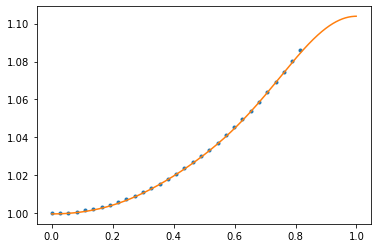

In [26]:
# CIC droop compensation filter

s = np.linspace(1e-9, .4*2*1.02, 31)

rm, n, k = 4, 7, 8*2
h = (np.sin(np.pi*rm*s/k)/(rm*np.sin(np.pi*s/k)))**n
rm, n, k = 8, 6, 64/3*2
h = h*(np.sin(np.pi*rm*s/k)/(rm*np.sin(np.pi*s/k)))**n

rm, n, k = 8, 7, 64/3*2
h = (np.sin(np.pi*rm*s/k)/(rm*np.sin(np.pi*s/k)))**n

rm, n, k = 5, 4, 20/1.*2
h = (np.sin(np.pi*rm*s/k)/(rm*np.sin(np.pi*s/k)))**n

rm, n, k = 5, 5, 20/1.*2
h = (np.sin(np.pi*rm*s/k)/(rm*np.sin(np.pi*s/k)))**n

#rm, n, k = 8*4, 8, 4*8*4
#h = (np.sin(np.pi*rm*s/k)/(rm*np.sin(np.pi*s/k)))**n

plt.plot(s, 1/np.absolute(h), ".")

ciccomp = FIR(signal.firls(
    9,
    np.repeat(s, 2)[1:-1],
    1/np.absolute(np.repeat(h, 2)[1:-1])
))
#ciccomp.b /= ciccomp.b.sum()
ciccomp.b *= .9995*(2.**9/5**4)
#ciccomp.b *= 1/ciccomp.b[len(ciccomp.b)//2]
ciccomp.quantize(1 << 16)
#ciccomp.b[3] -= 3
FIR(Gain(5**4/2.**9)(ciccomp([1.]))).plot_freq(plt.gca(), inset=False)
ciccomp.b, ciccomp.a

array([  -13,     0,    37,     0,   -87,     0,   175,     0,  -320,
           0,   546,     0,  -886,     0,  1395,     0, -2182,     0,
        3529,     0, -6465,     0, 20325, 32112, 20325,     0, -6465,
           0,  3529,     0, -2182,     0,  1395,     0,  -886,     0,
         546,     0,  -320,     0,   175,     0,   -87,     0,    37,
           0,   -13], dtype=int32)

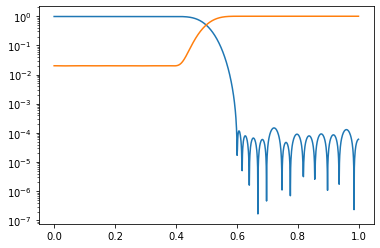

In [18]:
# tweaking passband gain
plt.yscale("log")
f = LPF(12*4 - 1, .4, 1-.4, g=(.99, .01))
f.quantize(1<<16)
f.b[len(f.b)//2] -= (1 << 16)/100
f.plot_freq(plt.gca())
#HBF(12, .4).b
f.b

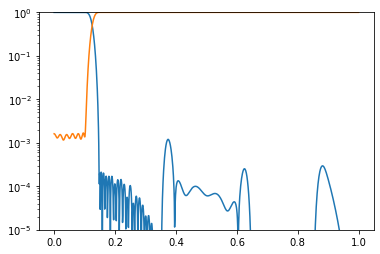

In [19]:
# example for bad design and errors in paper
# Kwentus 1997: wrong stopband width for last two FIR filters
def f(b):
    b = [sum((-2**k if k < 0 else 2**-k) for k in bi) for bi in b]
    bb = np.zeros((len(b) - 1)*4)
    bb[::2] = np.r_[b[:-1], b[-2::-1]]
    bb[len(b)*2 - 3] = b[-1]
    return bb

b = [
    [(-12, -14, -16),
     (10, -13, -15),
     (-9, 13, 14),
     (8, -11, -14),
     (-7, 9, 14, -16),
     (7, 9, -12, -16),
     (-6, 11, 12, -16),
     (6, 7, -11, -13),
     (-5, -8, 13, 15),
     (4, -7, 10, 14),
     (-4, -5, -7, 11),
     (2, 4, 8, -12),
     (1, -10, 12, -15)],
    [(-9, -11),
     (6, 10, 12, 14),
     (-4, -8, -10, -12),
     (2, 4, -7, -9, 11),
     (1,)],
    [(8, 9),
     (-5, -6, -9),
     (2, 5, 7, 8),
     (1,)]]

x = np.ones(1)
for bi in b:
    x = FIR(f(bi)/2)(US(2)(x))
    #x = DS(2)(FIR(f(bi)/2)(x))
plt.yscale("log")
plt.ylim(1e-5, 1.)
FIR(x).plot_freq(plt.gca())

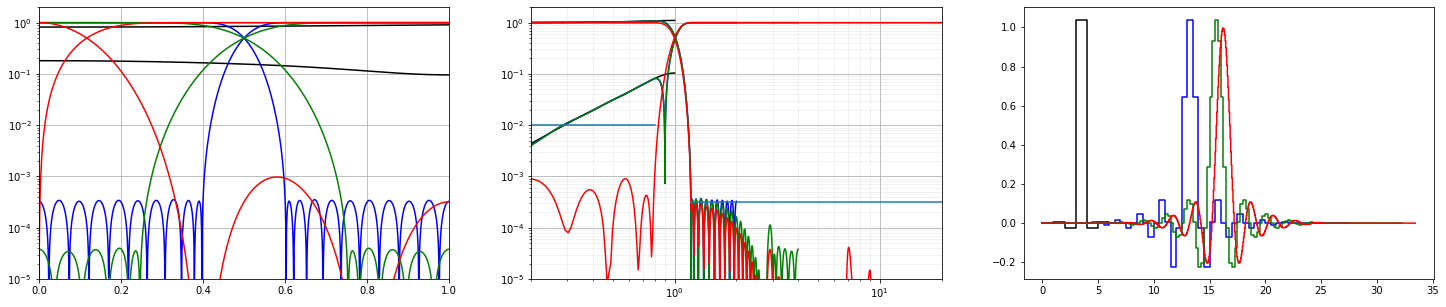

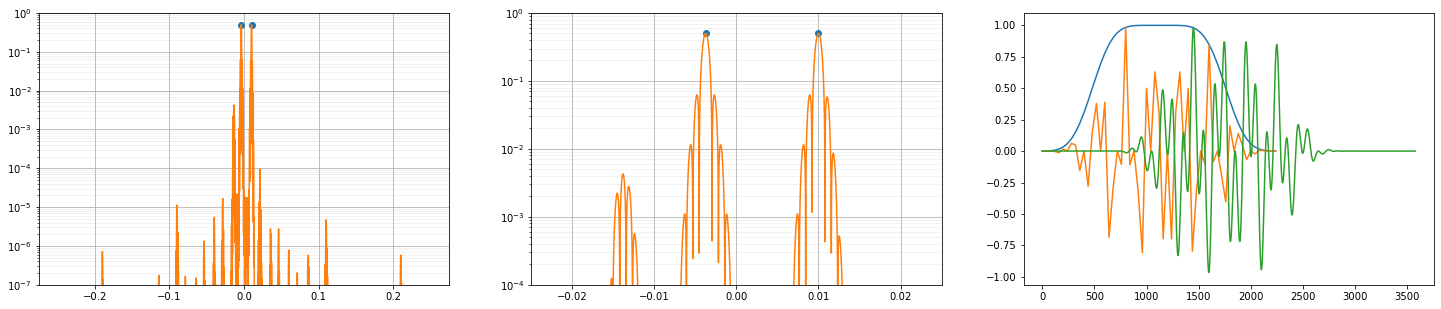

In [20]:
steps = [
    US(2), HBF(15, .4).quantize(1 << 17),
    US(2), HBF(6, 1/4/.993).quantize(1 << 15),
    US(2), HBF(3, 1/8).quantize(1 << 12),
    US(2), HBF(3, 1/16).quantize(1 << 9)]  # DAC34H84, 90dB
steps_ = [
    US(2), HBF(12, .4),
    US(2), HBF(6, 1/4),
    US(2), HBF(3, 1/8),
    US(2), HBF(2, 1/16)]  # 80 dB
steps_ = [
    US(2), HBF(16, .42),
    US(2), HBF(5, 1/4),
    US(2), HBF(3, 1/8),
    US(2), HBF(2, 1/16)]  # 84 dB
steps = [
    US(2), HBF(16, .42).quantize(1 << 17),
    US(2), HBF(5, 1/4*.999).quantize(1 << 15),
    US(2), HBF(3, 1/8).quantize(1 << 12),
    US(2), DS(3), HBF(4, .42/2*.85).quantize(1 << 14)]
steps = [
    US(2), HBF(16, .42).quantize(1 << 17),  # 16*3/32
    US(2), HBF(5, 1/4*.998).quantize(1 << 15),  # 5*3/16
    US(2), HBF(3, 1/8).quantize(1 << 12),  # 3*3/8
    DS(3), ciccomp,  # 4/4
    #US(8), CIC(8, 6)]
    CIC(8, 1, 6)]
steps = [
    ciccomp,
    US(2), HBF(13, .42).quantize(1 << 16),  # (5 + 13)*3/32
    US(2), HBF(5, 1/4*.998).quantize(1 << 15),  # 5*3/16
    US(2), CIC(2, 1, 5), DS(3), US(8), CIC(8, 1, 6)
    ]
steps = [
    ciccomp,
    US(2), HBF(13, .42).quantize(1 << 16),  # (5 + 13)*3/32
    US(4), CIC(4, 1, 7), DS(3), US(8), CIC(8, 1, 6)
    ]
# steps = [US(2), HBF(12, .4), US(2), HBF(5, .25), US(2), HBF(3, .1)]
# steps = [US(2), f0, US(2), f1, US(2), f2]
steps = [
    ciccomp,
    US(2), HBF(16, .42),
    US(2), HBF(5, 1/4),
    US(2), HBF(3, 1/8),
    DS(3),
    #CIC(3, 1, 3), DS(3),
    US(8), CIC(8, 1, 7)
    #US(4), CIC(4, 1, 7), DS(3), US(8), CIC(8, 1, 6)
    ]
steps = [
    Gain(5**4/2.**9),  # compensate ciccomp+cic+shift gain
    # 1/10
    ciccomp,
    # 1/10
    US(2), HBF(10, .4).quantize(1 << 18),
    # 1/5
    US(2), HBF(5, 1/4.).quantize(1 << 18),
    # 2/5
    US(5), CIC(5, 1, 5),
    # 2/1
    ]


fig, ax = plt.subplots(1, 3, figsize=(25, 5))
x = np.ones(1)
ax[2].step(np.arange(len(x)), x)
r = 1.

colors = list("kbgrcm")
last_rate = 1
for step in steps:
    r *= step.rate
    x = step(x)
    # print(step, x)
    if hasattr(step, "plot_freq"):
        color = colors.pop(0)
        step.plot_freq(ax[0], r=1, color=color)
        q = FIR(b=x)
        q.plot_freq(ax[1], r=r, f=1/r, color=color, inset=True, worN=2048)
        q.plot_time(ax[2], r=r, color=color)
    last_rate = step.rate

ax[0].grid()
ax[1].grid(which="minor", alpha=.2)
ax[0].set_ylim(1e-5, 2)
ax[0].set_xlim(0, 1)
ax[1].grid()
ax[1].grid(which="minor", alpha=.2)
ax[1].set_ylim(1e-5, 2)
#ax[1].set_ylim(.9, 1.1)
ax[1].set_xlim(1e-2*r, r)
ax[1].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[1].plot(np.array([1e-3, .4, np.nan, .6, 1e2])*2, [1e-2, 1e-2, np.nan, 1e-7**.5, 1e-7**.5])

m = 1 << 16
t0 = 10*4
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
a0 = np.ones(32)
a = CIC(6, 1, 5)(a0)
#a = np.convolve(signal.windows.hann(16)/8, a0)
af = np.array([(.5, .4), (.5, -.15)])
#af = np.array([(1., .42)])
t = np.arange(len(a))
y0 = sum(a*ai*np.exp(2j*np.pi*fi*t) for ai, fi in af)
y = y0
for step in steps:
    y = step(y)
# y *= np.exp(2j*np.pi*.1*np.arange(len(y))/r*t0)
ax[2].plot(t*t0, a, t*t0, y0.real, np.arange(len(y))/r*t0, y.real)
h = np.absolute(np.fft.fft(y, m)/r/len(a0))
s = np.fft.fftfreq(m)*r/t0
ax[0].plot(af[:, 1]/t0, np.absolute(af[:, 0]), "o", s, h)
ax[0].set_ylim(1e-7, 1)
ax[0].set_yscale("log")
#ax[0].set_xlim(-1/t0, 1/t0)
ax[0].grid()
ax[0].grid(which="minor", alpha=.2)
ax[1].plot(af[:, 1]/t0, np.absolute(af[:, 0]), "o", s, h)
ax[1].set_ylim(1e-4, 1)
ax[1].set_yscale("log")
ax[1].set_xlim(-1/t0, 1/t0)
ax[1].grid()
ax[1].grid(which="minor", alpha=.2);

In [21]:
for step in steps:
    if hasattr(step, "b"):
        print((list(step.b), step.a, len(step.b)))
    else:
        print(step.rate)

1
([24, -85, 281, -1314, 55862, -1314, 281, -85, 24], 65536, 9)
2
([-167, 0, 428, 0, -931, 0, 1776, 0, -3115, 0, 5185, 0, -8442, 0, 14028, 0, -26142, 0, 82873, 131072, 82873, 0, -26142, 0, 14028, 0, -8442, 0, 5185, 0, -3115, 0, 1776, 0, -931, 0, 428, 0, -167], 262144, 39)
2
([294, 0, -1865, 0, 6869, 0, -20436, 0, 80679, 131072, 80679, 0, -20436, 0, 6869, 0, -1865, 0, 294], 262144, 19)
5
([1, 5, 15, 35, 70, 121, 185, 255, 320, 365, 381, 365, 320, 255, 185, 121, 70, 35, 15, 5, 1], 3125, 21)


In [22]:
# usable bandwidth
1/(10*4e-3)*.8

20.0

In [23]:
# flatness
20*np.log10(1.001)

0.008681549586371858

In [24]:
# quantization snr
1.67+6.02*14

85.95

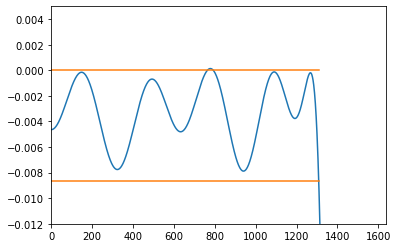

In [25]:
#plt.xscale("log")
plt.ylim(-.012, .005)
plt.xlim(0, (1<<16)/(2*r))
plt.plot(20*np.log10(np.absolute(np.fft.rfft(x/r, 1<<16))))
plt.plot(np.array([0, .4, np.nan, 0, .4])/20.*(1<<16), 20*np.log10([1-1e-3, 1-1e-3, np.nan, 1, 1]))

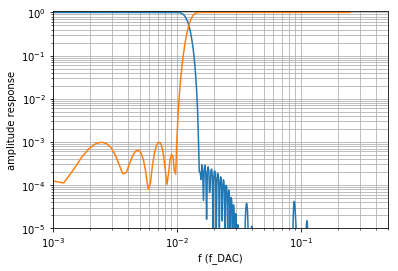

In [188]:
plt.xscale("log")
plt.xlabel("f (f_DAC)")
plt.xlim(1e-3, .5)
plt.yscale("log")
plt.ylim(1e-5, 1.1)
plt.ylabel("amplitude response")
plt.grid(which="both")
FIR(x).plot_freq(plt.gca(), r=r, f=4)

In [126]:
# overall impulse response of interpolation chain
x

array([-1.83970339e-12, -9.19851695e-12, -2.75955508e-11, -6.43896186e-11,
       -1.28779237e-10, -2.22604110e-10, -3.40345127e-10, -4.69124364e-10,
       -5.88705085e-10, -6.71491737e-10, -6.89256764e-10, -6.13140601e-10,
       -4.13651675e-10, -6.06664094e-11,  4.76570783e-10,  1.18949339e-09,
        2.03021281e-09,  2.91151834e-09,  3.70687718e-09,  4.25043444e-09,
        4.41306281e-09,  4.10236253e-09,  3.26266145e-09,  1.87501498e-09,
       -4.27939142e-11, -2.39384680e-09, -5.00208985e-09, -7.61233376e-09,
       -9.89025385e-09, -1.14223900e-08, -1.19175905e-08, -1.12070122e-08,
       -9.24412072e-09, -6.10468980e-09, -1.98680192e-09,  2.81829375e-09,
        7.92618131e-09,  1.28592781e-08,  1.70468348e-08,  1.98249353e-08,
        2.05400322e-08,  1.85489471e-08,  1.32188702e-08,  3.92736069e-09,
       -9.93765355e-09, -2.88808031e-08, -5.32992771e-08, -8.34828230e-08,
       -1.19613747e-07, -1.61766914e-07, -2.09383307e-07, -2.61270032e-07,
       -3.15600311e-07, -

In [28]:
FIR(x)([1.]).sum()/20.

0.9958505630493164

In [76]:
len(x)/20.

28.3